Data loaded successfully with 1067371 rows and 8 columns.
Column Names: Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Data after preprocessing has 805549 rows and 9 columns.
RFM metrics calculated for 5878 customers.
RFM values have been scaled.
K-Means clustering completed with 3 clusters.
DBSCAN clustering completed.
GMM clustering completed with 3 components.

Clustering Evaluation Metrics:
K-Means - Davies-Bouldin Index: 0.6347, Silhouette Score: 0.5803
DBSCAN - Davies-Bouldin Index: 0.8860, Silhouette Score: 0.8658
GMM - Davies-Bouldin Index: 1.5316, Silhouette Score: 0.1868

Evaluation Summary:
  Clustering Method  Davies-Bouldin Index  Silhouette Score
0           K-Means              0.634734          0.580285
1            DBSCAN              0.885953          0.865849
2               GMM              1.531612          0.186762

Best Clustering Method based on Davies-Bouldin Index: K-Mea

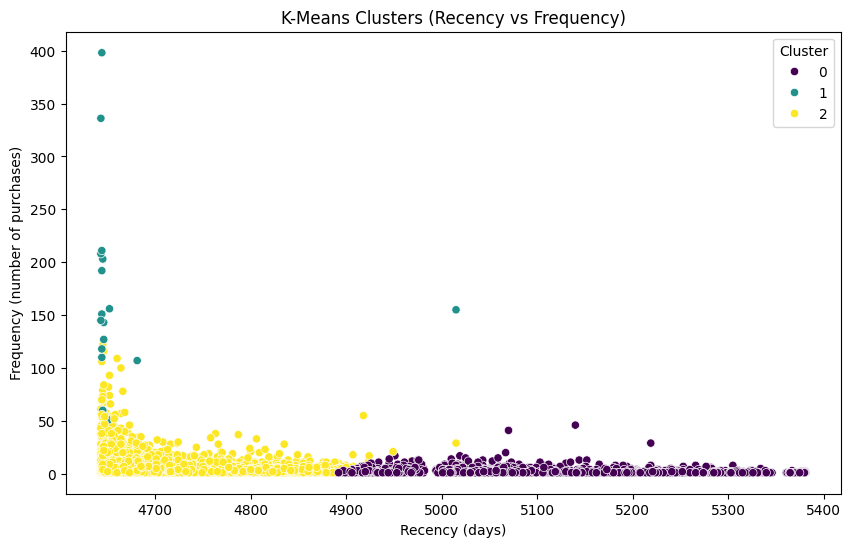

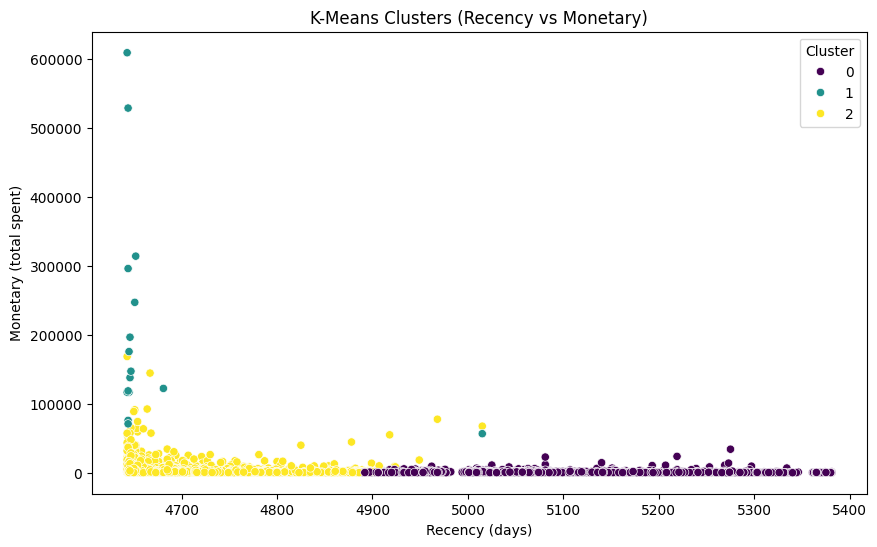


RFM analysis with cluster labels has been saved to 'rfm_with_clusters.csv'.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Load the Dataset
def load_data(file_path):
    """
    Load data from an Excel file, handling multiple sheets if present.
    """
    try:
        xls = pd.ExcelFile(file_path)
        sheet_names = xls.sheet_names
        df_list = []
        for sheet in sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet)
            df_list.append(df)
        data = pd.concat(df_list, ignore_index=True)
        print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# 2. Data Preprocessing
def preprocess_data(df):
    """
    Preprocess the dataset by handling missing values, removing cancelled orders,
    and calculating the TotalPrice.
    """
    # Print column names to ensure 'Customer ID' exists
    print("Column Names:", df.columns)

    # Check if 'Customer ID' exists
    if 'Customer ID' not in df.columns:
        raise KeyError("The 'Customer ID' column is missing from the dataset.")

    # Remove rows with missing Customer ID
    df = df.dropna(subset=['Customer ID'])

    # Ensure correct data types
    df['Customer ID'] = df['Customer ID'].astype(int)
    df['Invoice'] = df['Invoice'].astype(str)

    # Remove cancelled orders (Invoice starting with 'C')
    df = df[~df['Invoice'].str.startswith('C')]

    # Remove negative or zero Quantity or Price
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

    # Calculate TotalPrice
    df['TotalPrice'] = df['Quantity'] * df['Price']

    # Convert InvoiceDate to datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    print(f"Data after preprocessing has {df.shape[0]} rows and {df.shape[1]} columns.")

    return df

# 3. RFM Calculation
def calculate_rfm(df, reference_date):
    """
    Calculate Recency, Frequency, and Monetary values for each customer.
    """
    # Group by Customer ID
    rfm = df.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'Invoice': 'nunique',
        'TotalPrice': 'sum'
    })

    rfm.rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency',
        'TotalPrice': 'Monetary'
    }, inplace=True)

    print(f"RFM metrics calculated for {rfm.shape[0]} customers.")
    return rfm

# 4. Scaling RFM Values
def scale_rfm(rfm):
    """
    Scale the RFM values using StandardScaler.
    """
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm)
    print("RFM values have been scaled.")
    return rfm_scaled, scaler

# 5. Clustering Methods
def perform_kmeans(rfm_scaled, n_clusters=3):
    """
    Perform K-Means clustering.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(rfm_scaled)
    print(f"K-Means clustering completed with {n_clusters} clusters.")
    return kmeans_labels, kmeans

def perform_dbscan(rfm_scaled, eps=0.5, min_samples=5):
    """
    Perform DBSCAN clustering.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(rfm_scaled)
    print("DBSCAN clustering completed.")
    return dbscan_labels, dbscan

def perform_gmm(rfm_scaled, n_components=3):
    """
    Perform Gaussian Mixture Model clustering.
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm_labels = gmm.fit_predict(rfm_scaled)
    print(f"GMM clustering completed with {n_components} components.")
    return gmm_labels, gmm

# 6. Evaluation Metrics
def evaluate_clustering(rfm_scaled, labels, method_name):
    """
    Evaluate clustering using Davies-Bouldin Index and Silhouette Score.
    """
    db_index = davies_bouldin_score(rfm_scaled, labels)
    silhouette = silhouette_score(rfm_scaled, labels) if len(set(labels)) > 1 else -1
    print(f"{method_name} - Davies-Bouldin Index: {db_index:.4f}, Silhouette Score: {silhouette:.4f}")
    return db_index, silhouette

# 7. Main Function
def main():
    # File path
    file_path = '/content/online_retail_II.xlsx'

    # Load data
    data = load_data(file_path)
    if data is None:
        return

    # Preprocess data
    data = preprocess_data(data)

    # Set reference date
    reference_date = datetime.datetime(2024, 8, 26)

    # Calculate RFM
    rfm = calculate_rfm(data, reference_date)

    # Scale RFM
    rfm_scaled, scaler = scale_rfm(rfm)

    # Perform Clustering
    # K-Means
    kmeans_labels, kmeans_model = perform_kmeans(rfm_scaled, n_clusters=3)

    # DBSCAN
    # To determine appropriate eps, we might need to use a k-distance plot.
    # For simplicity, we'll use eps=1.0 and min_samples=5, adjust as needed.
    dbscan_labels, dbscan_model = perform_dbscan(rfm_scaled, eps=1.0, min_samples=5)

    # GMM
    gmm_labels, gmm_model = perform_gmm(rfm_scaled, n_components=3)

    # Evaluate Clustering
    print("\nClustering Evaluation Metrics:")
    kmeans_db, kmeans_sil = evaluate_clustering(rfm_scaled, kmeans_labels, "K-Means")
    dbscan_db, dbscan_sil = evaluate_clustering(rfm_scaled, dbscan_labels, "DBSCAN")
    gmm_db, gmm_sil = evaluate_clustering(rfm_scaled, gmm_labels, "GMM")

    # Compare Davies-Bouldin Index
    evaluation_df = pd.DataFrame({
        'Clustering Method': ['K-Means', 'DBSCAN', 'GMM'],
        'Davies-Bouldin Index': [kmeans_db, dbscan_db, gmm_db],
        'Silhouette Score': [kmeans_sil, dbscan_sil, gmm_sil]
    })

    print("\nEvaluation Summary:")
    print(evaluation_df)

    # Select the best clustering method based on Davies-Bouldin Index
    best_method = evaluation_df.loc[evaluation_df['Davies-Bouldin Index'].idxmin(), 'Clustering Method']
    print(f"\nBest Clustering Method based on Davies-Bouldin Index: {best_method}")

    # For this example, proceed with K-Means as per user request
    # Assign K-Means labels to RFM dataframe
    rfm['Cluster'] = kmeans_labels

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(rfm_scaled, kmeans_labels)
    print(f"\nK-Means Silhouette Score: {silhouette_avg:.4f}")

    # Analyze Clusters
    cluster_summary = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(2)
    cluster_summary.columns = ['Recency_mean', 'Frequency_mean', 'Monetary_mean', 'CustomerCount']
    print("\nCluster Summary:")
    print(cluster_summary)

    # Optional: Visualize the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm, palette='viridis')
    plt.title('K-Means Clusters (Recency vs Frequency)')
    plt.xlabel('Recency (days)')
    plt.ylabel('Frequency (number of purchases)')
    plt.legend(title='Cluster')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
    plt.title('K-Means Clusters (Recency vs Monetary)')
    plt.xlabel('Recency (days)')
    plt.ylabel('Monetary (total spent)')
    plt.legend(title='Cluster')
    plt.show()

    # Save the RFM with cluster labels to a CSV file
    rfm.to_csv('rfm_with_clusters.csv')
    print("\nRFM analysis with cluster labels has been saved to 'rfm_with_clusters.csv'.")

if __name__ == "__main__":
    main()
